In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [51]:
df = pd.read_csv("/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/dataset/energy_generated.csv")
df.head()

,period,value
0,2024-11-01T00,3094
1,2024-10-31T23,3233
2,2024-10-31T22,3235
3,2024-10-31T21,3045
4,2024-10-31T20,2985


In [52]:
df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%dT%H')

# Extract components from the 'period' column
# df['year'] = df['period'].dt.year
# df['month'] = df['period'].dt.month
# df['day'] = df['period'].dt.day
# df['time'] = df['period'].dt.time
# df['hours'] = df['period'].dt.hour
# df['minutes'] = df['period'].dt.minute
# df['seconds'] = df['period'].dt.second
df = df.set_index('period')
df.index = pd.to_datetime(df.index) 
print(df.index)

DatetimeIndex(['2024-11-01 00:00:00', '2024-10-31 23:00:00',
               '2024-10-31 22:00:00', '2024-10-31 21:00:00',
               '2024-10-31 20:00:00', '2024-10-31 19:00:00',
               '2024-10-31 18:00:00', '2024-10-31 17:00:00',
               '2024-10-31 16:00:00', '2024-10-31 15:00:00',
               ...
               '2023-01-01 09:00:00', '2023-01-01 08:00:00',
               '2023-01-01 07:00:00', '2023-01-01 06:00:00',
               '2023-01-01 05:00:00', '2023-01-01 04:00:00',
               '2023-01-01 03:00:00', '2023-01-01 02:00:00',
               '2023-01-01 01:00:00', '2023-01-01 00:00:00'],
              dtype='datetime64[ns]', name='period', length=16081, freq=None)


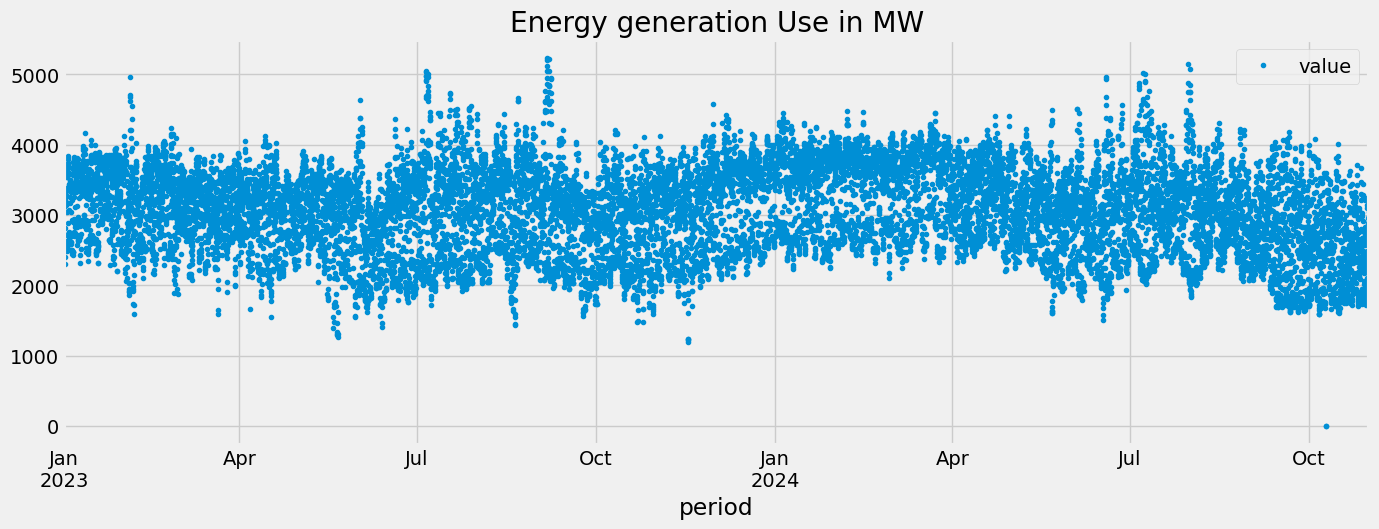

In [53]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy generation Use in MW')
plt.show()

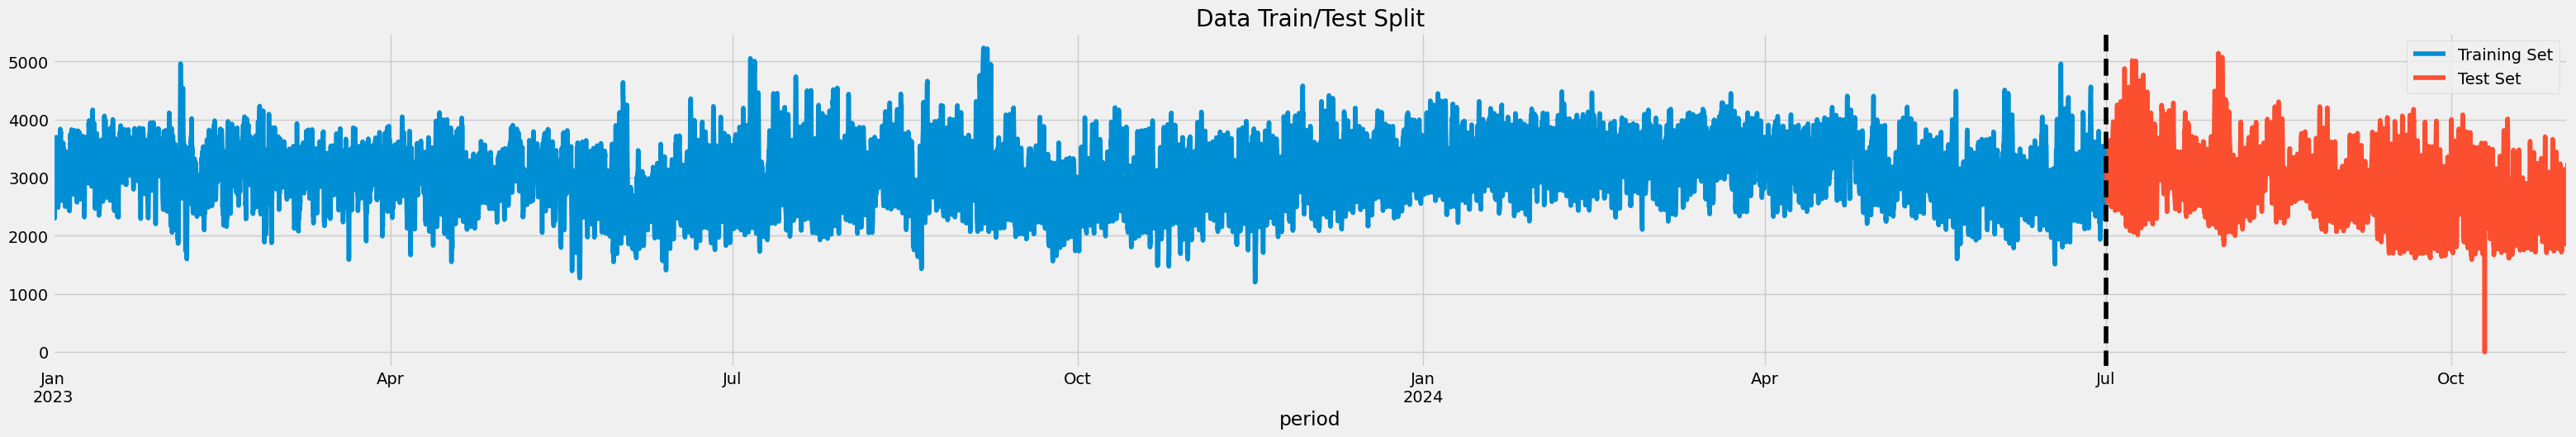

In [57]:
train = df.loc[df.index < '07-01-2024']
test = df.loc[df.index >= '07-01-2024']

fig, ax = plt.subplots(figsize=(35, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('07-01-2024', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

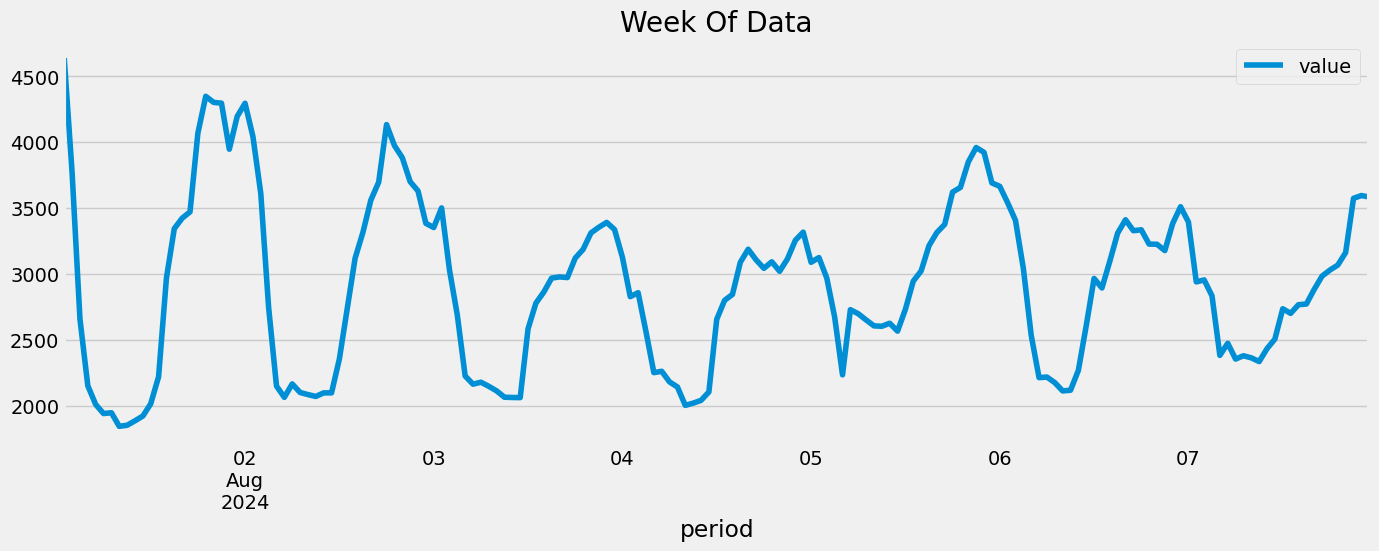

In [58]:
df.loc[(df.index > '08-01-2024') & (df.index < '08-08-2024')]\
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [62]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,value,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
period,,,,,,,,,
2024-11-01 00:00:00,3094,0,4,4,11,2024,306,1,44
2024-10-31 23:00:00,3233,23,3,4,10,2024,305,31,44
2024-10-31 22:00:00,3235,22,3,4,10,2024,305,31,44
2024-10-31 21:00:00,3045,21,3,4,10,2024,305,31,44
2024-10-31 20:00:00,2985,20,3,4,10,2024,305,31,44
...,...,...,...,...,...,...,...,...,...
2023-01-01 04:00:00,3116,4,6,1,1,2023,1,1,52
2023-01-01 03:00:00,3328,3,6,1,1,2023,1,1,52
2023-01-01 02:00:00,3323,2,6,1,1,2023,1,1,52


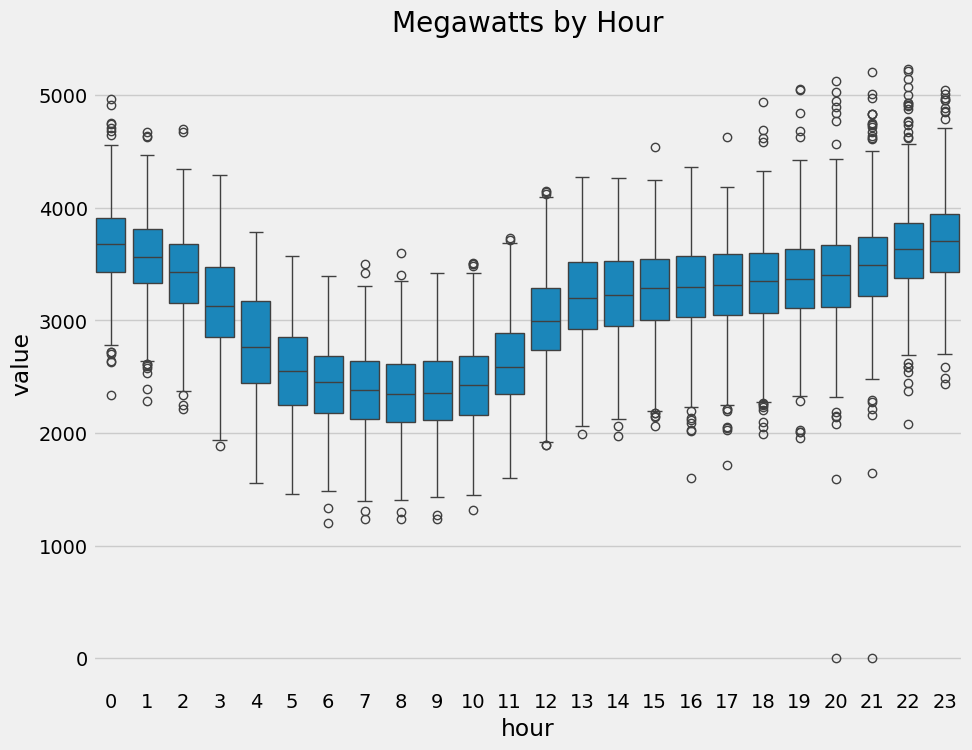

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='value')
ax.set_title('Megawatts by Hour')
plt.show()

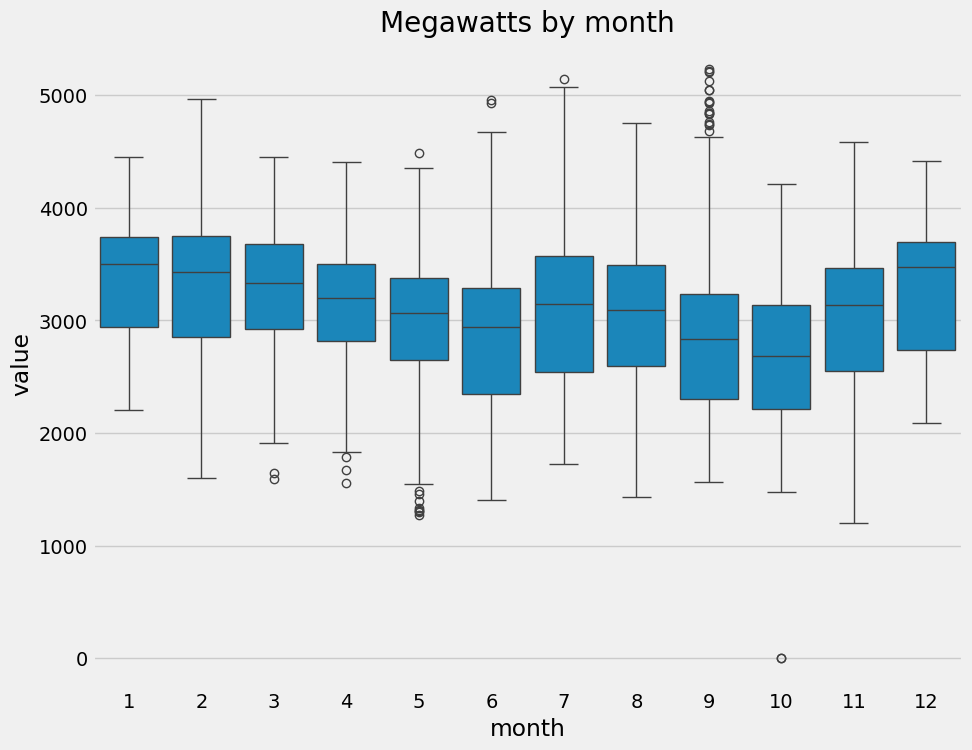

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='value')
ax.set_title('Megawatts by month')
plt.show()

In [66]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'value'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [71]:
reg = xgb.XGBRegressor(n_estimators= 1000,early_stopping_rounds = 50,learning_rate= 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:577.56554	validation_1-rmse:696.69091
[100]	validation_0-rmse:341.93765	validation_1-rmse:460.80155
[200]	validation_0-rmse:278.28687	validation_1-rmse:415.09874
[300]	validation_0-rmse:256.24784	validation_1-rmse:403.48864
[400]	validation_0-rmse:240.07866	validation_1-rmse:399.26152
[497]	validation_0-rmse:228.88077	validation_1-rmse:400.37979


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

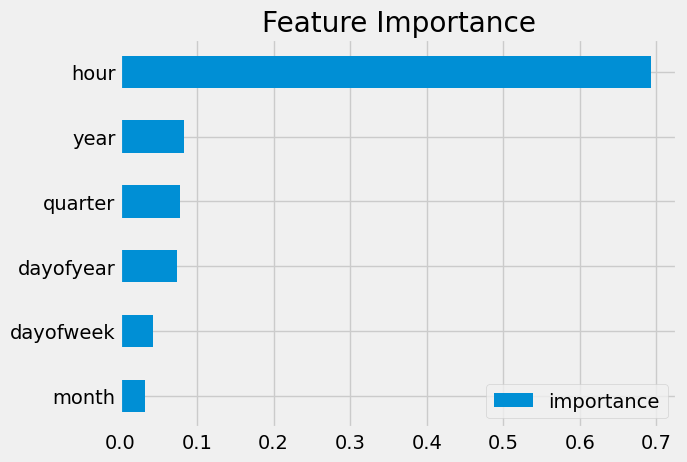

In [73]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

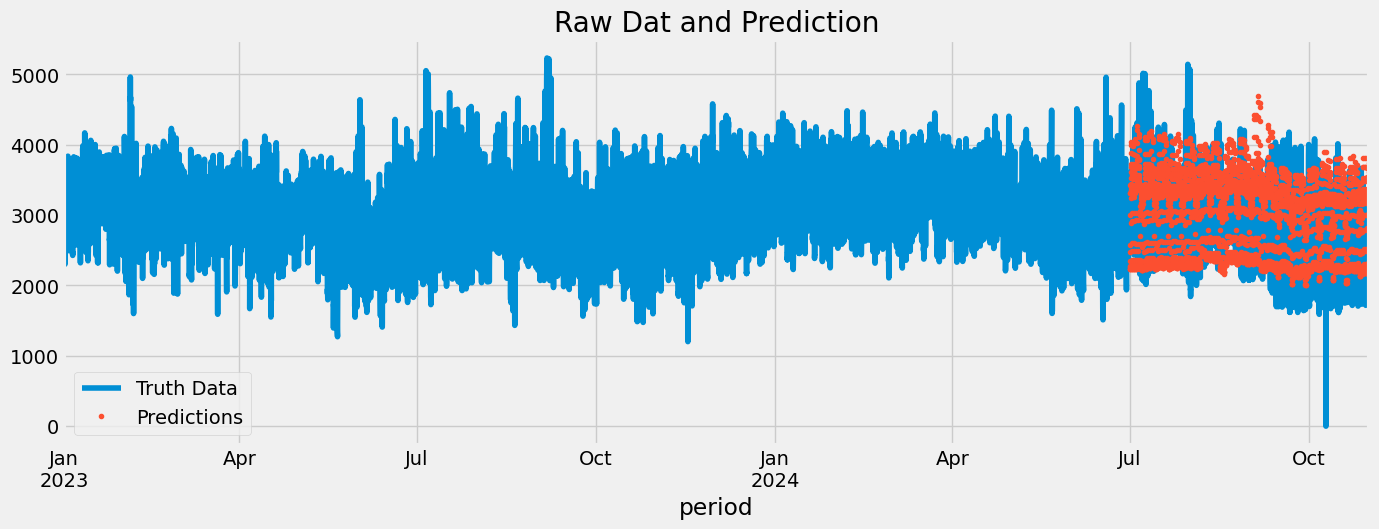

In [74]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['value']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

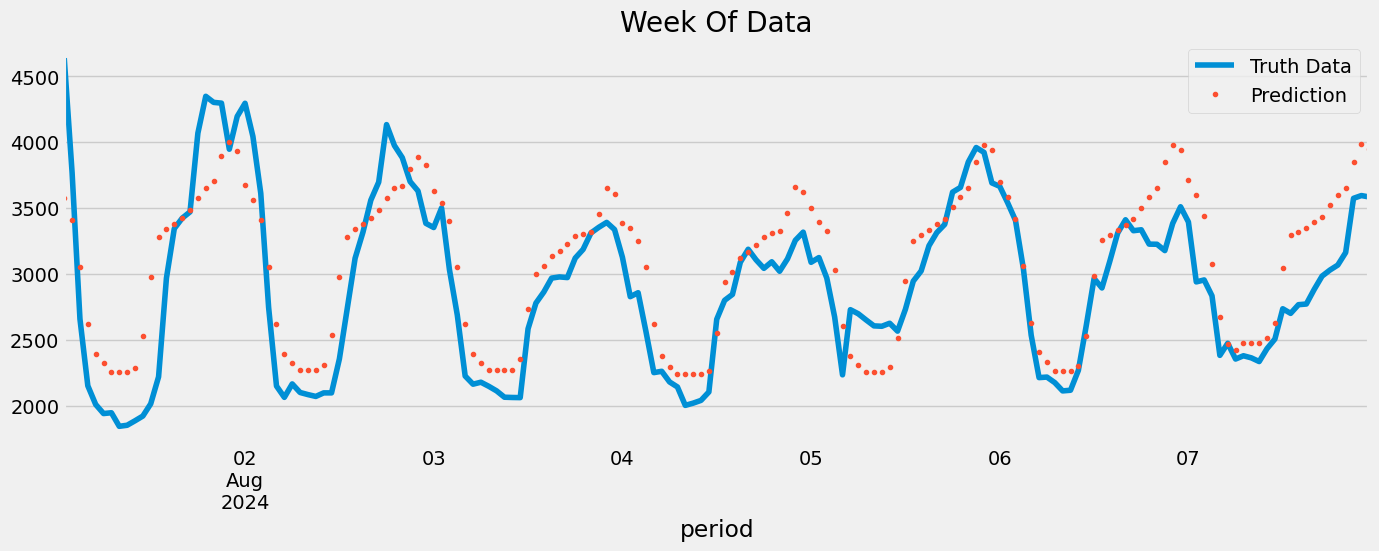

In [79]:
ax = df.loc[(df.index > '08-01-2024') & (df.index < '08-08-2024')]['value'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '08-01-2024') & (df.index < '08-08-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [81]:
score = np.sqrt(mean_squared_error(test['value'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 398.69


Calculate Error¶
Look at the worst and best predicted days

In [82]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-10-16    699.130432
2024-10-09    693.099721
2024-10-30    691.285706
2024-09-02    650.740824
2024-10-23    598.157735
2024-09-04    571.988037
2024-10-29    563.035278
2024-10-17    561.660726
2024-11-01    561.243408
2024-10-22    517.333110
Name: error, dtype: float64

In [83]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2024-07-13     75.398641
2024-08-09     94.016683
2024-07-28     94.425975
2024-07-14    108.452454
2024-07-27    110.233785
2024-08-10    119.889181
2024-07-29    128.238230
2024-08-26    136.677867
2024-07-11    155.334941
2024-07-12    155.383993
Name: error, dtype: float64

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

In [5]:
df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%dT%H')

# Extract components from the 'period' column
df['year'] = df['period'].dt.year
df['month'] = df['period'].dt.month
df['day'] = df['period'].dt.day
df['time'] = df['period'].dt.time
df['hours'] = df['period'].dt.hour
df['minutes'] = df['period'].dt.minute
df['seconds'] = df['period'].dt.second
df['day_of_week'] = df['period'].dt.day_name()  # Name of the day of the week (e.g., Monday)

# Display the updated DataFrame
print(df)

                  period  value  year  month  day      time  hours  minutes  \
0    2024-11-01 00:00:00   3094  2024     11    1  00:00:00      0        0   
1    2024-10-31 23:00:00   3233  2024     10   31  23:00:00     23        0   
2    2024-10-31 22:00:00   3235  2024     10   31  22:00:00     22        0   
3    2024-10-31 21:00:00   3045  2024     10   31  21:00:00     21        0   
4    2024-10-31 20:00:00   2985  2024     10   31  20:00:00     20        0   
...                  ...    ...   ...    ...  ...       ...    ...      ...   
8780 2023-11-01 04:00:00   2448  2023     11    1  04:00:00      4        0   
8781 2023-11-01 03:00:00   2729  2023     11    1  03:00:00      3        0   
8782 2023-11-01 02:00:00   3061  2023     11    1  02:00:00      2        0   
8783 2023-11-01 01:00:00   3140  2023     11    1  01:00:00      1        0   
8784 2023-11-01 00:00:00   3361  2023     11    1  00:00:00      0        0   

      seconds day_of_week  
0           0      Frid